## Neural Networks - Score: 0.88557

Validation set used in final model training.  Layers 200, 100. Feature engineering added.

In [1]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 20
pd.options.display.max_columns = 100

### Process Data

In [2]:
# define path to data
path = URLs.path('march-comp')

In [3]:
# read in training set
df = pd.read_csv(path/'train.csv', low_memory=False)

In [4]:
# read in test set
test = pd.read_csv(path/'test.csv', low_memory=False)

In [5]:
# drop id col
del df['id']
del test['id']

In [6]:
# define dependent var
dep_var = 'target'

In [7]:
# define continuous & categorical cols
cont,cat = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [8]:
# create feature engineering function for continuous cols (mostly polynomials)
def augment_df(df):
    for feature in cont:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
        df[f'repo_sq_{feature}'] = df[f'repo_{feature}']**2
        df[f'cube_{feature}'] = df[feature]**3
    
    # create cols for summary statistics
    df['min'] = df[cont].min(axis=1)
    df['mean'] = df[cont].mean(axis=1)
    df['max'] = df[cont].max(axis=1)
    df['sum'] = df[cont].sum(axis=1)
    df['median'] = df[cont].median(axis=1)
    df['std'] = df[cont].std(axis=1)
    df['var'] = df[cont].var(axis=1)
    df['abs_sum'] = df[cont].abs().sum(axis=1)
    df['abs_mean'] = df[cont].abs().mean(axis=1)
    df['abs_median'] = df[cont].abs().median(axis=1)
    df['abs_std'] = df[cont].abs().std(axis=1)
    df['skew'] = df[cont].skew(axis=1)
    df['kurt'] = df[cont].kurt(axis=1)
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in cont]].kurt(axis=1)

In [9]:
# apply feature engineering to train and test sets
augment_df(df)
augment_df(test)

In [10]:
df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,sq_cont0,repo_cont0,repo_sq_cont0,cube_cont0,sq_cont1,repo_cont1,repo_sq_cont1,cube_cont1,sq_cont2,repo_cont2,repo_sq_cont2,cube_cont2,sq_cont3,repo_cont3,repo_sq_cont3,cube_cont3,sq_cont4,repo_cont4,repo_sq_cont4,cube_cont4,sq_cont5,repo_cont5,repo_sq_cont5,cube_cont5,sq_cont6,repo_cont6,repo_sq_cont6,cube_cont6,sq_cont7,repo_cont7,repo_sq_cont7,cube_cont7,sq_cont8,repo_cont8,repo_sq_cont8,cube_cont8,sq_cont9,repo_cont9,repo_sq_cont9,cube_cont9,sq_cont10,repo_cont10,repo_sq_cont10,cube_cont10,min,mean,max,sum,median,std,var,abs_sum,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0,0.396721,1.587659,2.520662,0.249878,0.731622,1.169113,1.366826,0.625792,0.576747,1.316762,1.733862,0.438004,0.632899,1.256993,1.580032,0.503502,0.465011,1.466454,2.150486,0.317099,0.386476,1.608566,2.587484,0.240261,0.350682,1.688663,2.851584,0.207669,0.627138,1.262753,1.594544,0.496644,0.664639,1.226612,1.504577,0.541849,0.931237,1.036263,1.073840,0.898650,0.443443,1.501693,2.255082,0.295295,0.592184,0.743097,0.965006,8.174064,0.759439,0.115106,0.013249,8.174064,0.743097,0.759439,0.115106,0.449974,-0.434010,0.229683
1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0,0.137439,2.697402,7.275977,0.050952,0.108195,3.040166,9.242608,0.035588,0.149293,2.588093,6.698227,0.057685,0.293077,1.847178,3.412068,0.158662,0.151307,2.570810,6.609064,0.058856,0.128005,2.795027,7.812178,0.045798,0.360052,1.666546,2.777374,0.216047,0.167037,2.446776,5.986713,0.068268,0.159482,2.504053,6.270281,0.063690,0.860082,1.078277,1.162680,0.797645,0.243769,2.025402,4.102252,0.120356,0.328929,0.473036,0.927406,5.203401,0.399353,0.172145,0.029634,5.203401,0.473036,0.399353,0.172145,2.124580,4.972017,7.441472
2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0,0.252277,1.990954,3.963899,0.126712,0.104167,3.098384,9.599986,0.033620,0.117824,2.913288,8.487248,0.040444,0.379889,1.622451,2.632346,0.234145,0.629939,1.259943,1.587456,0.499974,0.305673,1.808721,3.271472,0.168999,0.123984,2.839994,8.065568,0.043656,0.151193,2.571786,6.614083,0.058789,0.169994,2.425400,5.882565,0.070089,0.085671,3.416520,11.672606,0.025075,0.301898,1.819994,3.312378,0.165879,0.292696,0.466054,0.793687,5.126590,0.412303,0.152722,0.023324,5.126590,0.466054,0.412303,0.152722,0.952043,0.519183,2.513934
3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0,0.872808,1.070387,1.145727,0.815414,0.500787,1.413102,1.996858,0.354388,0.690806,1.203156,1.447584,0.574162,0.652552,1.237920,1.532445,0.527136,0.640052,1.249949,1.562373,0.512062,0.383343,1.615125,2.608628,0.237346,0.049190,4.508791,20.329200,0.010910,0.805716,1.114061,1.241131,0.723225,0.401537,1.578110,2.490432,0.254441,0.578084,1.315239,1.729853,0.439528,0.872809,1.070386,1.145727,0.815415,0.221789,0.740698,0.934242,8.147675,0.800032,0.203155,0.041272,8.147675,0.740698,0.800032,0.203155,-1.795295,4.052710,0.999065
4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1,0.064733,3.930395,15.448001,0.016470,0.075358,3.642805,13.270030,0.020687,0.114798,2.951438,8.710984,0.038895,0.076900,3.606103,13.003979,0.021325,0.372806,1.637792,2.682363,0.227627,0.016459,7.794778,60.758562,0.002111,0.334968,1.727819,2.985359,0.193868,0.077934,3.582084,12.831323,0.021757,0.123273,2.848170,8.112072,0.043282,0.127509,2.800465,7.842603,0.045531,0.108215,3.039885,9.240900,0.035598,0.128291,0.343547,0.61057

In [11]:
# define new continuous & categorical cols
cont,cat = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [13]:
# no validation set
splits = RandomSplitter(valid_pct=0.)(range_of(df))

In [14]:
# create tabularpandas object
procs = [Categorify, Normalize]
to = TabularPandas(df, procs, cat, cont, 
                   y_names=dep_var, y_block=CategoryBlock, splits=splits)

In [15]:
# create dataloader object
dls = to.dataloaders(1024)

### Train Neural Net

In [16]:
# create learner
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0014454397605732083)

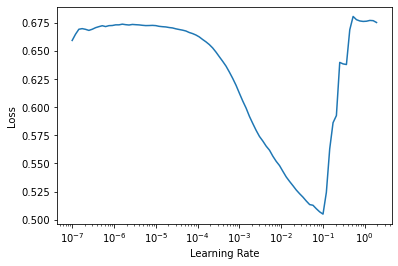

In [17]:
# checking learning rates
learn.lr_find()

In [18]:
# training learner 5 epochs
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.364767,None,None,00:16
1,0.357110,None,None,00:17
2,0.348215,None,None,00:17
3,0.342668,None,None,00:17
4,0.335639,None,None,00:17


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


### Submit Predictions

In [19]:
# convert test set to fastai tabular dataloader
test_dl = dls.test_dl(test, bs=1024)

In [20]:
# checking length of test set & dataloader - make sure same length
len(test), len(test_dl.train.xs)

(200000, 200000)

In [21]:
# get preds for test set
test_preds,test_targs = learn.get_preds(dl=test_dl)

In [22]:
# get probability = 1
sub_y = test_preds[:,1]

In [23]:
# read in test set again for id col
test = pd.read_csv(path/'test.csv', low_memory=False)

In [24]:
# create submission df
submission = pd.DataFrame({"id": test.id,"target": sub_y})

In [25]:
# save submission to csv
submission.to_csv('NN005.csv', index=False)